In [20]:
import os
import re
from itertools import chain

import numpy as np

import torch
import torch.utils.data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [90]:
def load_task(data_dir, task_id, only_supporting=False):
    assert task_id > 0 and task_id <= 20
    files = os.listdir(data_dir)
    files = [os.path.join(data_dir, f) for f in files]
    s = "qa{}_".format(task_id)
    train_file = [f for f in files if s in f and 'train' in f][0]
    test_file  = [f for f in files if s in f and 'test'  in f][0]
    train_data = get_stories(train_file, only_supporting)
    test_data  = get_stories(test_file,  only_supporting)
    return train_data, test_data

def tokenize(sent):
    return [x.strip() for x in re.split("(\W+)?", sent) if x.strip()]

def parse_stories(lines, only_supporting=False):
    data  = []
    story = []
    for line in lines:
        nid, line = line.lower().split(" ", 1)
        nid  = int(nid)
        if nid == 1:
            story = []
        if '\t' in line: #question
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            a = [a]
            substory = None
            if q[-1] == "?":
                q = q[:-1]
            
            if only_supporting:
                supporting = map(int, supporting.split())
                substory   = [story[i - 1] for i in supporting]
            else:
                substory   = [x for x in story if x]
            
            data.append((substory, q, a))
            story.append("")
        else:
            sent = tokenize(line)
            if sent[-1] == '.':
                sent = sent[:-1]
            story.append(sent)
    return data

def get_stories(f, only_supporting=False):
    with open(f) as f:
        return parse_stories(f.readlines(), only_supporting=only_supporting)
        
def vectorize_data(data, word_idx, sentence_size, memory_size):
    S, Q, A = [], [], []
    for story, query, answer in data:
        ss = []
        for i, sentence in enumerate(story, 1):
            ls = max(0, sentence_size - len(sentence))
            ss.append([word_idx[w] for w in sentence] + [0] * ls)
        
        ss = ss[::-1][:memory_size][::-1]
        
        for i in range(len(ss)):
            ss[i][-1] = len(word_idx) - memory_size - i + len(ss)
        
        lm = max(0, memory_size - len(ss))
        for _ in range(lm):
            ss.append([0] * sentence_size)
        
        lq = max(0, sentence_size - len(query))
        q = [word_idx[w] for w in query] + [0] * lq
        
        y = np.zeros(len(word_idx) + 1)
        for a in answer:
            y[word_idx[a]] = 1
        
        S.append(ss)
        Q.append(q)
        A.append(y)
    return np.array(S), np.array(Q), np.array(A)

class bAbIDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, task_id=1, memory_size=50, train=True):
        self.train       = train
        self.task_id     = task_id
        self.dataset_dir = dataset_dir
        
        train_data, test_data = load_task(self.dataset_dir, task_id)
        data = train_data + test_data
        
        self.vocab = set([])
        for story, query, answer in data:
            self.vocab = self.vocab | set(list(chain.from_iterable(story)) + query + answer)
        self.vocab = sorted(self.vocab)
        print(len(self.vocab))
        word_idx = {word:i+1 for i, word in enumerate(self.vocab)}
        
        self.max_story_size = max([len(story) for story, _, _ in data])
        self.query_size     = max([len(query) for _, query, _ in data])
        self.sentence_size  = max([len(row) for row in chain.from_iterable([story for story, _, _ in data])])
        self.memory_size    = max(memory_size, self.max_story_size)
        
        for i in range(self.memory_size):
            word_idx["time{}".format(i+1)] = "time{}".format(i + 1)
        
        self.num_vocab = len(word_idx)

        self.sentence_size = max(self.sentence_size, self.query_size)
        self.sentence_size += 1
        self.word_idx      = word_idx
        
        self.mean_story_size = int(np.mean([len(s) for s, _, _ in data]))
        
        if train:
            story, query, answer = vectorize_data(train_data, self.word_idx, self.sentence_size, self.memory_size)
        else:
            story, query, answer = vectorize_data(test_data, self.word_idx, self.sentence_size, self.memory_size)
         
        self.data_story  = torch.LongTensor(story)
        self.data_query  = torch.LongTensor(query)
        self.data_answer = torch.LongTensor(np.argmax(answer, axis=1))
    
    def __getitem__(self, idx):
        return self.data_story[idx], self.data_query[idx], self.data_answer[idx]
    
    def __len__(self):
        return len(self.data_story)

In [115]:
batch_size = 32

data_dir = 'tasks_1-20_v1-2/en-10k'
train_data = bAbIDataset(data_dir, 3)
val_data   = bAbIDataset(data_dir, 3, train=False)
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=1, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=batch_size, num_workers=1, shuffle=True)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


34
354
34
354


In [116]:
def position_encoding(sentence_size, embedding_dim):
    encoding = np.ones((embedding_dim, sentence_size), dtype=np.float32)
    ls = sentence_size + 1
    le = embedding_dim + 1
    for i in range(1, le):
        for j in range(1, ls):
            encoding[i-1, j-1] = (i - (embedding_dim+1)/2) * (j - (sentence_size+1)/2)
    encoding = 1 + 4 * encoding / embedding_dim / sentence_size
    encoding[:, -1] = 1.0
    return torch.FloatTensor(np.transpose(encoding))


In [127]:
def weights_init(m):
    if isinstance(m, nn.Embedding):
        m.weight.data.normal_(0, 0.1)
        
def gradient_clip_noise(params, clip=40.0, std=0.001):
    
    params = [param for param in params if param.grad is not None]
    nn.utils.clip_grad_norm_(params, clip)
    
    for param in params:
        noise = torch.randn(param.size()).to(param.device) * std
        param.grad.data.add_(noise)

def lr_optimzer(optimizer, epoch, decay, decay_freq):
    if epoch != 0 and epoch%decay_freq == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * decay
        
class MemN2N(nn.Module):
    def __init__(self, vocab_size, emb_size, mem_hops, sentence_size):
        super(MemN2N, self).__init__()
        self.mem_hops = mem_hops
        
        self.embs = nn.ModuleList([nn.Embedding(vocab_size+10, emb_size, padding_idx=0) for _ in range(mem_hops + 1)])
        self.pe = nn.Parameter(position_encoding(sentence_size+1, emb_size), requires_grad = False)
        
        self.apply(weights_init)
        
    def forward(self, story, question):
        
        question_len = question.size(1)
        seq_len = story.size(2)
               
        question_emb = self.embs[0](question)
        question_emb = (question_emb *self.pe[:question_len,].unsqueeze(0)).sum(dim=1)     
        
        u = question_emb
        
        for hop in range(self.mem_hops):
            emb_a = self.embs[hop](story)
            emb_a = (emb_a * self.pe[:seq_len,].unsqueeze(0).unsqueeze(0)).sum(dim=2)           

            logits = (u.unsqueeze(1) * emb_a).sum(dim = 2)
            probs = F.softmax(logits, dim = 1)
            
            emb_c = self.embs[hop + 1](story)
            emb_c = (emb_c * self.pe[:seq_len].unsqueeze(0).unsqueeze(0)).sum(dim=2)
            
            output = ((probs.unsqueeze(2) * emb_c).sum(dim=1))
            
            u = output + u
            
        weights_output = self.embs[-1].weight.transpose(0, 1)
    
        return u.matmul(weights_output) 
            

In [128]:
model  = MemN2N((train_data.num_vocab), 20, 3, 7)
# optimizer = optim.SGD([param for param in model.parameters() if param.requires_grad], lr=0.01)
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])
criterion = nn.CrossEntropyLoss()
losses = []

In [129]:
class Trainer:
    def __init__(self, dataset, test_dataset, model,  decoder_optimizer, criterion, batch_size):
        
        
        self.dataset = dataset
        self.test_dataset = test_dataset
        self.train_losses = []
        self.val_losses = []
        self.batch_size = batch_size
        
        self.model = model

        self.decoder_optimizer = decoder_optimizer
        self.criterion = criterion
        
               
    def train(self, n_epochs):
        
        mask_words = None
        for epoch in range(n_epochs):

            for contexts, questions, answers in self.dataset:
            
                self.decoder_optimizer.zero_grad()
                
                logits = self.model(contexts, questions)
                
                loss = self.criterion(logits, answers)                        
                loss.backward()
                
                gradient_clip_noise(self.model.parameters())
                
                self.decoder_optimizer.step()

                self.train_losses.append(loss.item())
                
#                 if batch_idx % 200 == 0:
            val_losses = self.eval_()
            self.val_losses.append(val_losses)
            self.plot(epoch, 0, self.train_losses, self.val_losses)                  
            lr_optimzer(self.decoder_optimizer, epoch, 0.5, 25)
            
            
    def eval_(self):
        
        accs = []
        with torch.no_grad():
            for contexts, questions, answers in self.test_dataset:

                logits = self.model(contexts, questions)

                acc = self.accuracy(logits, answers)
                accs.append(acc)

        return np.mean(np.array(accs))
        
    def accuracy(self, logits, answers):        
#         correct = 0
#         for en, lg in enumerate(logits):

#             ans = lg.argmax()#.item()     
#             if ans == answers[en].item():
#                 correct += 1 
        correct = torch.argmax(logits, 1) == answers

        
        return correct.sum().item()/(len(logits))
 
    def plot(self, epoch, batch_idx, train_losses, val_losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('epoch %s. | batch: %s | loss: %s' % (epoch, batch_idx, train_losses[-1]))
        plt.plot(train_losses)
        plt.subplot(132)
        plt.title('epoch %s. | acc: %s' % (epoch, val_losses[-1]))
        plt.plot(val_losses)
        plt.show()  

In [130]:
trainer = Trainer(train_loader, val_loader, model,  optimizer, criterion, batch_size = 32)

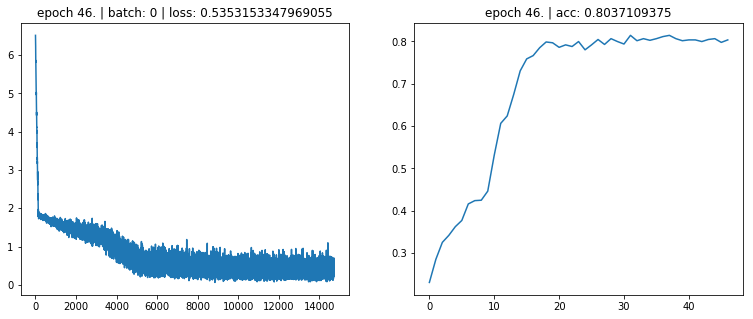

Process Process-584:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/oljike/PycharmProjects/TopicModelling/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt


In [131]:
trainer.train(1000)